<a href="https://colab.research.google.com/github/saltycookie/RLIntroNotebook/blob/main/Chapter_5_Blackjack_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import abc
import matplotlib.pyplot as plt
import enum
from dataclasses import dataclass
import copy


In [2]:
class DiscreteEnv(abc.ABC):
  def __init__(self, gamma=1.0):
    self.gamma = gamma

  @abc.abstractmethod
  def num_states(self):
    pass

  @abc.abstractmethod
  def num_actions(self):
    pass

  @abc.abstractmethod
  def init(self):
    pass

  @abc.abstractmethod
  def possible_actions(self, state):
    pass

  @abc.abstractmethod
  def step(self, action):
    pass

  @abc.abstractmethod
  def is_terminal(self):
    pass

  @abc.abstractmethod
  def init(self):
    pass

class PlayerAction(enum.Enum):
  HIT = 0
  STAND = 1


@dataclass
class BlackjackState:
  player_sum: int
  player_has_ace: bool
  dealer_first_card: int
  dealer_sum: int
  dealer_has_ace: bool
  is_terminal: bool

  def player_largest_sum(self):
    if self.player_sum <= 11 and self.player_has_ace:
      return self.player_sum + 10
    return self.player_sum

  def dealer_largest_sum(self):
    if self.dealer_sum <= 11 and self.dealer_has_ace:
      return self.dealer_sum + 10
    return self.dealer_sum

  def player_busted(self):
    return self.player_sum > 21

  def dealer_busted(self):
    return self.dealer_sum > 21

  def encode_visible_state(self):
    if self.is_terminal:
      return self.max_visible_state_code()
    return ((self.player_sum - 2) * 10 + (
        self.dealer_first_card - 1)) * 2 + int(self.player_has_ace)

  def to_visible_state(self):
    if self.is_terminal:
      return copy.copy(self)
    return BlackjackState(self.player_sum, self.player_has_ace,
                          self.dealer_first_card, None, None, False)

  @classmethod
  def max_visible_state_code(self):
    return 20 * 10 * 2

  @classmethod
  def decode_visible_state(cls, state):
    if state == cls.max_visible_state_code():
      return cls(None, None, None, None, None, True)
    player_has_ace = True if state % 2 else False
    state //= 2
    dealer_first_card = state % 10 + 1
    state //= 10
    player_sum = state + 2
    return cls(player_sum, player_has_ace, dealer_first_card, None, None, False)


class BlackjackPlayerEnv(DiscreteEnv):
  def __init__(self, gamma=1.0):
    super().__init__(gamma)
    self.state = None

  def init(self):
    player_sum = 0
    player_has_ace = False
    for _ in range(2):
      card = self.draw_card()
      if card == 1:
        player_has_ace = True
      player_sum += card
    dealer_first_card = self.draw_card()
    dealer_second_card = self.draw_card()
    self.state = BlackjackState(
        player_sum, player_has_ace, dealer_first_card,
        dealer_first_card + dealer_second_card,
        dealer_second_card == 1 or dealer_first_card == 1,
        False)
    player_is_natural = 1 if self.state.player_largest_sum() == 21 else 0
    dealer_is_natural = 1 if self.state.dealer_largest_sum() == 21 else 0
    self.state.is_terminal = player_is_natural or dealer_is_natural
    return self.state.to_visible_state(), player_is_natural - dealer_is_natural

  def is_terminal(self):
    return self.state.is_terminal

  def num_states(self):
    return BlackjackState.max_visible_state_code() + 1

  def num_actions(self):
    return 2

  def possible_actions(self, state):
    return [PlayerAction.HIT.value, PlayerAction.STAND.value]

  def step(self, action):
    if action == PlayerAction.HIT:
      card = self.draw_card()
      if card == 1:
        self.state.player_has_ace = True
      self.state.player_sum += card
      if self.state.player_busted():
        self.state.is_terminal = True
        return self.state.to_visible_state(), -1
      else:
        return self.state.to_visible_state(), 0
    if action == PlayerAction.STAND:
      self.state.is_terminal = True
      while self.state.dealer_largest_sum() < 17:
        card = self.draw_card()
        if card == 1:
          self.state.dealer_has_ace = True
        self.state.dealer_sum += card
      if self.state.dealer_busted() or (
          self.state.player_largest_sum() > self.state.dealer_largest_sum()):
        return self.state.to_visible_state(), 1
      elif self.state.player_largest_sum() == self.state.dealer_largest_sum():
        return self.state.to_visible_state(), 0
      else:
        return self.state.to_visible_state(), -1

  def draw_card(self):
    num = np.random.randint(1, 13)
    if num >= 10:
      return 10
    else:
      return num


In [4]:
@dataclass
class Step:
  state: int
  action: int
  reward: int


class OnPolicyMonteCarloAgent:
  def __init__(self, env, epsilon=0.01, init_q_value=0.0):
    self.env = env
    self.epsilon = epsilon
    self.q_values = np.zeros(
        (env.num_states(), env.num_actions())) + init_q_value
    self.n = np.zeros((env.num_states(), env.num_actions()), dtype=int)

  def act(self, state):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.env.possible_actions(state))
    return np.argmax(self.q_values[state.encode_visible_state()])

  def update(self, steps: list[Step]):
    acc_reward = 0
    for step in reversed(steps):
      state, action, reward = step.state, step.action, step.reward
      self.n[state, action] += 1
      acc_reward *= self.env.gamma
      acc_reward += step.reward
      self.q_values[state, action] += (
          acc_reward - self.q_values[state, action]) / self.n[state, action]


class OffPolicyMonteCarloAgent:
  def __init__(self, env, epsilon=0.01, init_q_value=0.0):
    self.env = env
    self.epsilon = epsilon
    self.q_values = np.zeros(
        (env.num_states(), env.num_actions())) + init_q_value
    self.n = np.zeros((env.num_states(), env.num_actions()), dtype=int)
    self.c = np.zeros((env.num_states(), env.num_actions()), dtype=float)

  def act_on_policy(self, state):
    return np.argmax(self.q_values[state.encode_visible_state()])

  def act_off_policy(self, state):
    if np.random.random() < self.epsilon:
      return np.random.choice(self.env.possible_actions(state))
    return self.act_on_policy(state)

  def update(self, steps: list[Step]):
    acc_reward = 0
    w = 1.0
    for step in reversed(steps):
      state, action, reward = step.state, step.action, step.reward
      self.n[state, action] += 1
      self.c[state, action] += w
      acc_reward *= self.env.gamma
      acc_reward += step.reward
      old_best_action = np.argmax(self.q_values[state])
      self.q_values[state, action] += (
          acc_reward - self.q_values[state, action]) / self.c[state, action] * w
      if old_best_action != np.argmax(self.q_values[state]):
        break
      w *= len(self.env.possible_actions(state))


In [5]:
env = BlackjackPlayerEnv()
on_policy_agent = OnPolicyMonteCarloAgent(env, epsilon=0.05)
reward_sum = 0.0
avg_rewards = []
for it in range(100000):
  state, reward = env.init()
  steps = []
  while not state.is_terminal:
    action = on_policy_agent.act(state)
    new_state, reward = env.step(PlayerAction(action))
    steps.append(Step(state.encode_visible_state(), action, reward))
    state = new_state
  reward_sum += reward
  avg_rewards.append(reward_sum / (it + 1))
  on_policy_agent.update(steps)

reward_sum = 0.0
for it in range(1000):
  state, reward = env.init()
  while not state.is_terminal:
    action = on_policy_agent.act(state)
    new_state, reward = env.step(PlayerAction(action))
    state = new_state
  reward_sum += reward
reward_sum / 1000

-0.139

In [14]:
np.mean(on_policy_agent.n), np.std(on_policy_agent.n), np.count_nonzero(on_policy_agent.n > 10)

(np.float64(187.0286783042394), np.float64(330.3648710976401), 550)

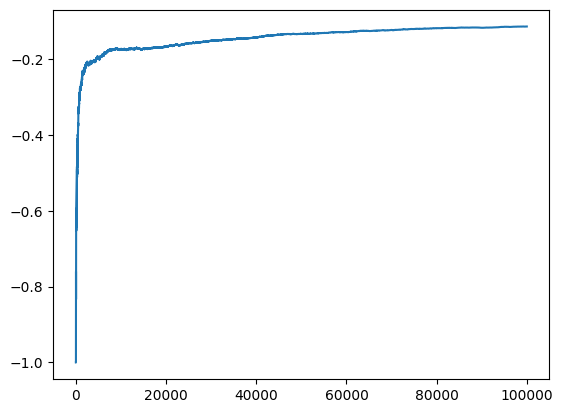

In [7]:
plt.plot(avg_rewards)

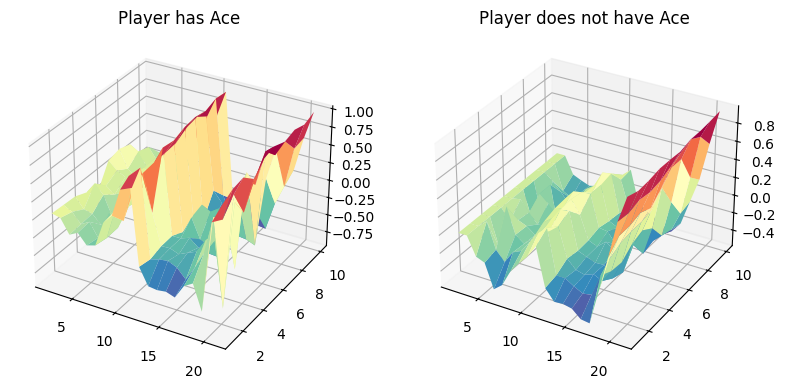

In [8]:
x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))

Z = np.max(on_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player has Ace')

Z = np.max(on_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player does not have Ace')

plt.show()

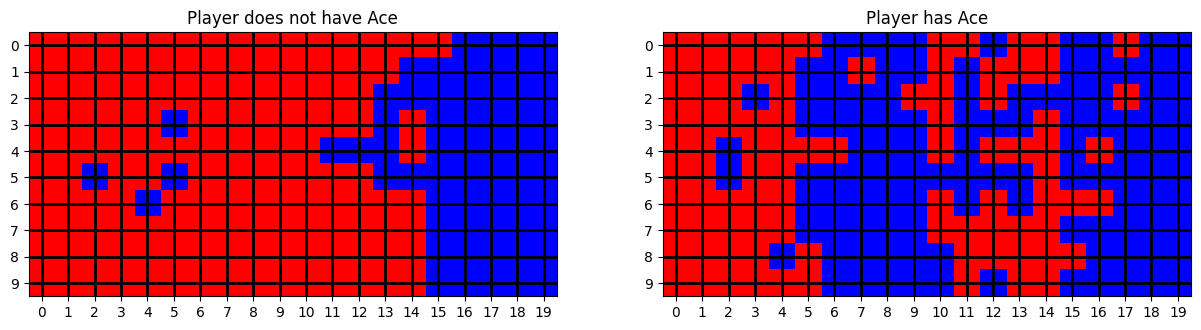

In [9]:
from matplotlib import colors

x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-1, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15, 30))

Z = np.argmax(on_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player does not have Ace')

Z = np.argmax(
    on_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player has Ace')

plt.show()

In [29]:
env = BlackjackPlayerEnv()
off_policy_agent = OffPolicyMonteCarloAgent(env, epsilon=0.2)
for it in range(100000):
  state, reward = env.init()
  steps = []
  while not state.is_terminal:
    action = off_policy_agent.act_off_policy(state)
    new_state, reward = env.step(PlayerAction(action))
    steps.append(Step(state.encode_visible_state(), action, reward))
    state = new_state
  off_policy_agent.update(steps)

reward_sum = 0.0
for it in range(1000):
  state, reward = env.init()
  while not state.is_terminal:
    action = off_policy_agent.act_on_policy(state)
    new_state, reward = env.step(PlayerAction(action))
    state = new_state
  reward_sum += reward
reward_sum / 1000

-0.013

In [30]:
np.mean(off_policy_agent.n), np.std(off_policy_agent.n), np.count_nonzero(off_policy_agent.n > 10)

(np.float64(186.9862842892768), np.float64(312.61055670115564), 706)

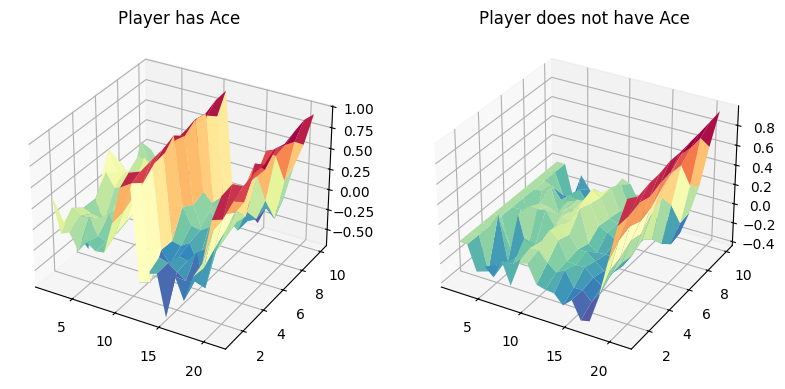

In [31]:
x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=plt.figaspect(0.5))

Z = np.max(off_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player has Ace')

Z = np.max(off_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='Spectral_r')
ax.set_title('Player does not have Ace')

plt.show()

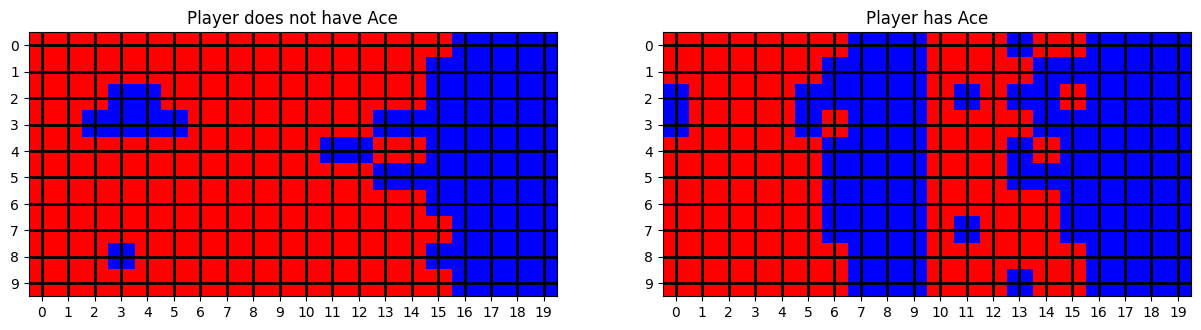

In [32]:
from matplotlib import colors

x = np.linspace(2, 21, 20, dtype=int)
y = np.linspace(1, 10, 10, dtype=int)
X, Y = np.meshgrid(x, y)

cmap = colors.ListedColormap(['red', 'blue'])
bounds = [-1, 0.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(15, 30))

Z = np.argmax(off_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2], axis=-1)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player does not have Ace')

Z = np.argmax(off_policy_agent.q_values[((X - 2) * 10 + (Y - 1)) * 2 + 1], axis=-1)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(Z, cmap=cmap, norm=norm)
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0, 20, 1));
ax.set_yticks(np.arange(0, 10, 1));
ax.set_title('Player has Ace')

plt.show()